In [156]:
import os
import numpy as np
import pandas as pd
import torch
from PIL import Image

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
import sys
!conda update --yes --prefix {sys.prefix} 

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [138]:
class CustomData(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        path = self.X[i]
        data = Image.open("dataset/Train Images/"+path)
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data

In [225]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

data_dir = "dataset/Train Images"
classes = ['Food', 'Attire', 'Decorationandsignage', 'misc']
class_map = {'Food':0, 'Attire':1, 'Decorationandsignage':2, 'misc':3}

df = pd.read_csv("dataset/train.csv").replace({'Class':class_map})
rem = []
for i, n in df.iterrows():
    image = Image.open("dataset/Train Images/"+n['Image'])
    if image.mode == 'L' or image.mode != 'RGB':
        rem.append(n['Image'])
df = df[~df.Image.isin(rem)]

In [226]:
split = np.random.rand(len(df)) < 0.8
train = df[split]
test = df[~split]

train_images = train.iloc[:,0].to_numpy()
train_labels = train.iloc[:,1].to_numpy()
test_images = test.iloc[:,0].to_numpy()
test_labels = test.iloc[:,1].to_numpy()

In [227]:
train_data = CustomData(train_images, train_labels, transform)
test_data = CustomData(test_images, test_labels, transform)

# dataloaders
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=True, drop_last=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 3, 224, 224)


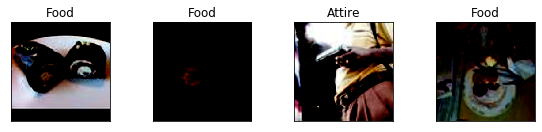

In [229]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
print(images.shape)
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(4):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [230]:
net = torchvision.models.squeezenet1_1(pretrained=False, progress=True).to(device)
net

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [231]:
# import torch.nn as nn

# n_inputs = net.classifier[6].in_features

# last_layer = nn.Linear(n_inputs, len(classes))

# net.classifier[6] = last_layer

# net.to(device)

# # check to see that your last layer produces the expected number of outputs
# print(net.classifier[6].out_features)
# # print(net)

In [232]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(net.classifier.parameters(), lr=0.001)

In [234]:
# number of epochs to train the model
n_epochs = 2

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = net(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

Epoch 1, Batch 20 loss: 6.9354795455932621
Epoch 1, Batch 40 loss: 6.6321522951126095
Epoch 1, Batch 60 loss: 6.1837250709533693
Epoch 1, Batch 80 loss: 5.7089806556701657
Epoch 1, Batch 100 loss: 5.3481733560562130
Epoch 1, Batch 120 loss: 4.9850102424621578
Epoch 1, Batch 140 loss: 4.5416766166687008
Epoch 1, Batch 160 loss: 3.5591359376907348
Epoch 1, Batch 180 loss: 3.7184174776077272
Epoch 1, Batch 200 loss: 2.9051797211170198
Epoch 1, Batch 220 loss: 2.7127679049968720
Epoch 1, Batch 240 loss: 2.2701726138591765
Epoch 1, Batch 260 loss: 2.3747650086879730
Epoch 1, Batch 280 loss: 2.3073544800281525
Epoch 1, Batch 300 loss: 2.1399126470088961
Epoch 1, Batch 320 loss: 1.9401655554771424
Epoch 1, Batch 340 loss: 2.0828830599784851
Epoch 1, Batch 360 loss: 1.8224779665470123
Epoch 1, Batch 380 loss: 1.7546660125255584
Epoch 1, Batch 400 loss: 1.7508274734020233
Epoch 1, Batch 420 loss: 1.8613255381584168
Epoch 1, Batch 440 loss: 1.7024911105632783
Epoch 1, Batch 460 loss: 1.732443106